In [2]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Removing data points:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-6-59b95c126e7d>:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(self.linear.bias.data.cpu().numpy())
Removing data points:  60%|██████    | 3/5 [00:03<00:02,  1.08s/it]<ipython-input-6-59b95c126e7d>:230: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-logit))
Epoch 5/5: 100%|██████████| 32/32 [00:00<00:00, 39.93it/s]
<ipython-input-6-59b95c126e7d>:302: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(self.linear.bias.data.cpu().numpy())
Epoch 5/5: 100%|██████████| 32/32 [00:00<00:00, 39.90it/s]


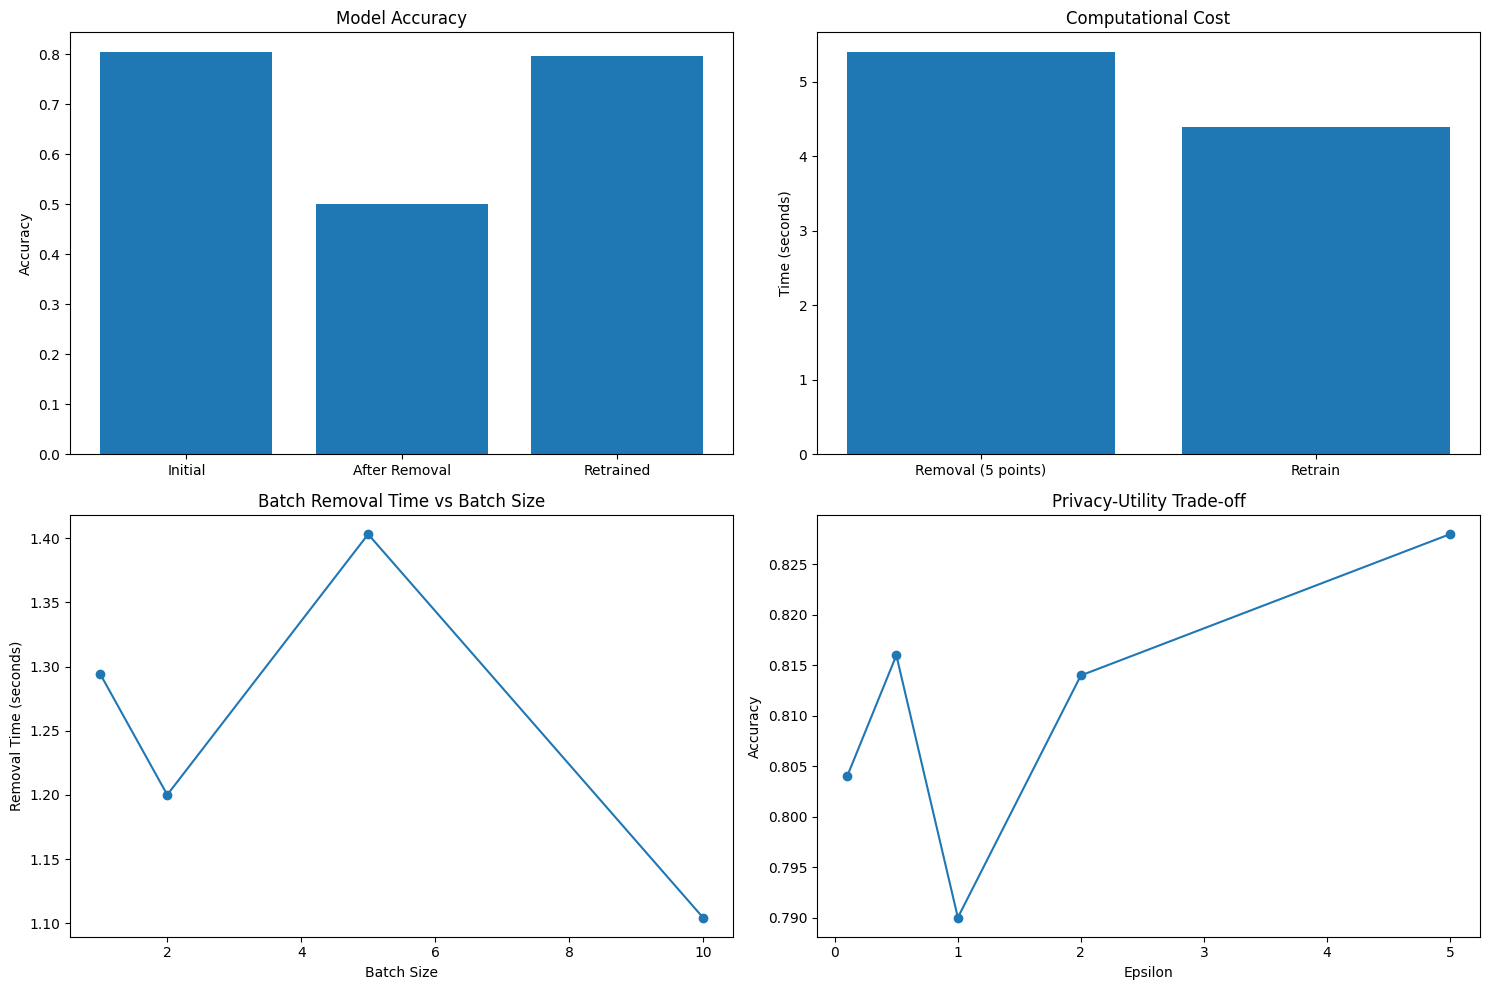

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import time
import logging
import os
import pickle
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class FeatureExtractor:
    def __init__(self, model_name="distilbert-base-uncased", device=None, cache_dir="cached_features"):
        """
        Initialize the feature extractor.

        Args:
            model_name: Pretrained model name
            device: Device to use for computation
            cache_dir: Directory to cache extracted features
        """
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.model_name = model_name
        self.cache_dir = cache_dir

        # Create cache directory if it doesn't exist
        os.makedirs(cache_dir, exist_ok=True)

        logger.info(f"Using device: {self.device}")

    def load_model(self):
        """Load the model only when needed to save memory."""
        logger.info(f"Loading {self.model_name}...")
        self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
        self.model.eval()

    def get_cache_path(self, split):
        """Get path for cached features."""
        return os.path.join(self.cache_dir, f"{self.model_name.replace('/', '_')}_{split}_features.pkl")

    def extract_features(self, dataset, split="train", batch_size=32, force_recompute=False):
        """
        Extract features from the dataset.

        Args:
            dataset: Dataset to extract features from
            split: Split name (train/test)
            batch_size: Batch size for extraction
            force_recompute: Whether to force recomputation even if cache exists

        Returns:
            Dictionary containing features, labels, and indices
        """
        cache_path = self.get_cache_path(split)

        # Check if features are already cached
        if os.path.exists(cache_path) and not force_recompute:
            logger.info(f"Loading cached features from {cache_path}")
            with open(cache_path, 'rb') as f:
                return pickle.load(f)

        # Load model if not already loaded
        if not hasattr(self, 'model'):
            self.load_model()

        logger.info(f"Extracting features for {split} split...")
        start_time = time.time()

        features_list = []
        labels_list = []
        indices_list = []

        # Create dataloader with appropriate batch size
        dataloader = DataLoader(dataset, batch_size=batch_size)
        total_batches = len(dataloader)

        # Extract features in batches
        with torch.no_grad():
            for i, batch in enumerate(tqdm(dataloader, desc=f"Extracting {split} features")):
                input_ids, attention_mask, labels = batch

                # Move to device
                input_ids = input_ids.to(self.device)
                attention_mask = attention_mask.to(self.device)

                # Extract features
                outputs = self.model(input_ids, attention_mask=attention_mask)
                features = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding

                # Store features and labels
                features_list.append(features.cpu())
                labels_list.append(labels)
                indices_list.extend(range(i*batch_size, min((i+1)*batch_size, len(dataset))))

                # Log progress every 10% of batches
                if (i + 1) % max(1, total_batches // 10) == 0:
                    elapsed = time.time() - start_time
                    estimated_total = elapsed / (i + 1) * total_batches
                    remaining = estimated_total - elapsed
                    logger.info(f"Processed {i+1}/{total_batches} batches "
                               f"({(i+1)/total_batches*100:.1f}%) - "
                               f"Time: {elapsed:.1f}s / Est. remaining: {remaining:.1f}s")

        # Concatenate features and labels
        features = torch.cat(features_list, dim=0)
        labels = torch.cat(labels_list, dim=0)
        indices = torch.tensor(indices_list)

        # Create result dictionary
        result = {
            "features": features,
            "labels": labels,
            "indices": indices
        }

        # Cache the features
        logger.info(f"Caching features to {cache_path}")
        with open(cache_path, 'wb') as f:
            pickle.dump(result, f)

        total_time = time.time() - start_time
        logger.info(f"Feature extraction completed in {total_time:.2f} seconds")

        # Free up memory
        if hasattr(self, 'model'):
            del self.model
            torch.cuda.empty_cache()

        return result

    def extract_features_from_dataset(self, tokenized_datasets, batch_size=32, force_recompute=False):
        """Extract features from both train and test splits."""
        train_features = self.extract_features(
            tokenized_datasets["train"],
            split="train",
            batch_size=batch_size,
            force_recompute=force_recompute
        )

        test_features = self.extract_features(
            tokenized_datasets["test"],
            split="test",
            batch_size=batch_size,
            force_recompute=force_recompute
        )

        return train_features, test_features


class CertifiedRemovalClassifier(nn.Module):
    """Linear classifier with certified removal support."""

    def __init__(self, input_dim, lambda_reg=0.01, epsilon=1.0, delta=1e-4):
        super(CertifiedRemovalClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.lambda_reg = lambda_reg
        self.epsilon = epsilon
        self.delta = delta
        self.perturbation_vector = None
        self.feature_dim = input_dim
        self.C = 1.0  # Bound on loss gradient norm

    def forward(self, x):
        return self.linear(x)

    def add_perturbation(self, n_samples):
        """Add random perturbation to the loss function."""
        # Compute standard deviation based on epsilon and delta
        c = np.sqrt(2 * np.log(1.5 / self.delta))
        sigma = (self.C / (self.lambda_reg * np.sqrt(n_samples))) * c / self.epsilon

        # Generate perturbation vector
        self.perturbation_vector = torch.normal(0, sigma, size=(self.feature_dim,))
        logger.info(f"Added perturbation with sigma = {sigma}")

        # Add perturbation to linear layer weights
        with torch.no_grad():
            self.linear.weight.data += self.perturbation_vector.view(1, -1) / n_samples

    def compute_l2_regularization(self):
        """Compute L2 regularization term."""
        return 0.5 * self.lambda_reg * torch.sum(self.linear.weight ** 2)

    def save_original_weights(self):
        """Save original weights for comparison."""
        self.original_weight = self.linear.weight.data.clone()
        self.original_bias = self.linear.bias.data.clone()

    def remove_data_point(self, feature, label, return_gradient_norm=False):
        """
        Remove a data point using the Newton update.

        Args:
            feature: Feature vector to remove
            label: Label to remove
            return_gradient_norm: Whether to return the gradient residual norm

        Returns:
            Time taken for removal, (optionally) gradient residual norm
        """
        start_time = time.time()

        # Move data to CPU for numpy operations
        feature = feature.cpu().numpy()
        label = float(label.cpu().numpy())

        # Get current weights
        w = self.linear.weight.data.cpu().view(-1).numpy()
        b = float(self.linear.bias.data.cpu().numpy())

        # Compute sigmoid
        logit = np.dot(w, feature) + b
        p = 1 / (1 + np.exp(-logit))

        # Compute gradient contribution of the removed point
        w_grad = (p - label) * feature + self.lambda_reg * w
        b_grad = (p - label)

        # Compute second-order derivative for Hessian
        d = p * (1 - p)

        # Form Hessian matrix
        outer_product = np.outer(feature, feature)
        # Add extra regularization to ensure numerical stability
        H_w = d * outer_product + self.lambda_reg * np.eye(self.feature_dim) + 1e-6 * np.eye(self.feature_dim)
        h_wb = d * feature
        h_b = d + 1e-6  # Small constant for numerical stability

        # Solve linear system for Newton update
        combined_grad = np.concatenate([w_grad, [b_grad]])

        # Form combined Hessian
        H = np.zeros((self.feature_dim + 1, self.feature_dim + 1))
        H[:self.feature_dim, :self.feature_dim] = H_w
        H[:self.feature_dim, -1] = h_wb
        H[-1, :self.feature_dim] = h_wb
        H[-1, -1] = h_b

        # Compute Newton update
        try:
            update = np.linalg.solve(H, combined_grad)
        except np.linalg.LinAlgError:
            # Use pseudo-inverse as fallback for numerical stability
            logger.warning("Singular matrix encountered. Using pseudo-inverse.")
            update = np.linalg.lstsq(H, combined_grad, rcond=None)[0]

        # Apply update
        w_update = update[:self.feature_dim]
        b_update = update[-1]

        # Update model parameters
        with torch.no_grad():
            self.linear.weight.data -= torch.FloatTensor(w_update).view(1, -1).to(self.linear.weight.device)
            self.linear.bias.data -= torch.FloatTensor([b_update]).to(self.linear.bias.device)

        removal_time = time.time() - start_time

        if return_gradient_norm:
            # Compute gradient residual norm to measure removal quality
            # This is an approximation since we don't actually measure on D\x
            grad_norm = np.linalg.norm(np.concatenate([w_grad, [b_grad]]))
            return removal_time, grad_norm

        return removal_time

    def batch_remove(self, features, labels):
        """
        Remove a batch of data points.

        Args:
            features: Feature matrix of points to remove
            labels: Labels of points to remove

        Returns:
            Time taken for batch removal
        """
        start_time = time.time()

        # Move data to CPU for numpy operations
        features = features.cpu().numpy()
        labels = labels.cpu().numpy()

        # Get current weights
        w = self.linear.weight.data.cpu().view(-1).numpy()
        b = float(self.linear.bias.data.cpu().numpy())

        # Batch gradient contribution
        m = features.shape[0]

        # Compute logits and probabilities
        logits = np.dot(features, w) + b
        probs = 1 / (1 + np.exp(-logits))

        # Compute gradient
        w_grad = np.zeros_like(w)
        b_grad = 0.0

        for i in range(m):
            w_grad += (probs[i] - labels[i]) * features[i]
            b_grad += (probs[i] - labels[i])

        w_grad += m * self.lambda_reg * w

        # Compute Hessian
        H_w = np.zeros((self.feature_dim, self.feature_dim))
        h_wb = np.zeros(self.feature_dim)
        h_b = 0.0

        for i in range(m):
            d = probs[i] * (1 - probs[i])
            H_w += d * np.outer(features[i], features[i])
            h_wb += d * features[i]
            h_b += d

        # Add extra regularization for numerical stability
        H_w += m * self.lambda_reg * np.eye(self.feature_dim) + 1e-6 * np.eye(self.feature_dim)
        h_b += 1e-6  # Small constant for stability

        # Form combined gradient and Hessian
        combined_grad = np.concatenate([w_grad, [b_grad]])

        H = np.zeros((self.feature_dim + 1, self.feature_dim + 1))
        H[:self.feature_dim, :self.feature_dim] = H_w
        H[:self.feature_dim, -1] = h_wb
        H[-1, :self.feature_dim] = h_wb
        H[-1, -1] = h_b

        # Compute Newton update
        try:
            update = np.linalg.solve(H, combined_grad)
        except np.linalg.LinAlgError:
            # Use pseudo-inverse as fallback for numerical stability
            logger.warning("Singular matrix encountered in batch removal. Using pseudo-inverse.")
            update = np.linalg.lstsq(H, combined_grad, rcond=None)[0]

        # Apply update
        w_update = update[:self.feature_dim]
        b_update = update[-1]

        # Update model parameters
        with torch.no_grad():
            self.linear.weight.data -= torch.FloatTensor(w_update).view(1, -1).to(self.linear.weight.device)
            self.linear.bias.data -= torch.FloatTensor([b_update]).to(self.linear.bias.device)

        batch_removal_time = time.time() - start_time
        return batch_removal_time


class CertifiedRemovaLTrainer:
    """Trainer class for certified removal."""

    def __init__(self, lambda_reg=0.01, epsilon=1.0, delta=1e-4, device=None):
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        self.lambda_reg = lambda_reg
        self.epsilon = epsilon
        self.delta = delta
        self.classifier = None

        logger.info(f"Using device: {self.device}")

    def train(self, train_features, add_perturbation=True):
        """Train the linear classifier with certified removal support."""
        logger.info("Training linear classifier...")

        features = train_features["features"].to(self.device)
        labels = train_features["labels"].to(self.device)

        # Initialize classifier if not already done
        if self.classifier is None:
            input_dim = features.shape[1]
            self.classifier = CertifiedRemovalClassifier(
                input_dim=input_dim,
                lambda_reg=self.lambda_reg,
                epsilon=self.epsilon,
                delta=self.delta
            ).to(self.device)

        # Add perturbation for certified removal
        if add_perturbation:
            self.classifier.add_perturbation(n_samples=len(features))

        # Create dataloader
        train_dataset = TensorDataset(features, labels.float())
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Training setup
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.classifier.parameters(), lr=0.001, weight_decay=0)  # No weight decay in optimizer as we handle it manually

        # Training loop
        n_epochs = 5
        for epoch in range(n_epochs):
            total_loss = 0
            for batch_features, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
                # Move to device
                batch_features = batch_features.to(self.device)
                batch_labels = batch_labels.to(self.device)

                # Forward pass
                outputs = self.classifier(batch_features)
                loss = criterion(outputs.view(-1), batch_labels)

                # Add L2 regularization
                loss += self.classifier.compute_l2_regularization()

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            logger.info(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")

        # Save original weights for comparison
        self.classifier.save_original_weights()

        logger.info("Training completed")

    def evaluate(self, test_features):
        """Evaluate the model on test data."""
        features = test_features["features"].to(self.device)
        labels = test_features["labels"].to(self.device)

        # Create dataloader
        test_dataset = TensorDataset(features, labels.float())
        test_loader = DataLoader(test_dataset, batch_size=64)

        # Evaluation
        self.classifier.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                # Move to device
                batch_features = batch_features.to(self.device)

                # Forward pass
                outputs = self.classifier(batch_features)
                preds = (torch.sigmoid(outputs.view(-1)) > 0.5).float()

                # Store predictions and labels
                all_preds.append(preds.cpu())
                all_labels.append(batch_labels)

        # Concatenate predictions and labels
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        # Calculate accuracy
        accuracy = (all_preds == all_labels).float().mean().item()

        return accuracy

    def remove_data_point(self, train_features, idx):
        """Remove a data point using the Newton update."""
        feature = train_features["features"][idx].to(self.device)
        label = train_features["labels"][idx].to(self.device)

        return self.classifier.remove_data_point(feature, label)

    def batch_remove(self, train_features, indices):
        """Remove a batch of data points."""
        features = train_features["features"][indices].to(self.device)
        labels = train_features["labels"][indices].to(self.device)

        return self.classifier.batch_remove(features, labels)

    def retrain_from_scratch(self, train_features, indices_to_remove):
        """Retrain the classifier from scratch without the removed data points."""
        # Create mask for remaining data
        mask = torch.ones(len(train_features["features"]), dtype=bool)
        mask[indices_to_remove] = False

        # Get remaining data
        remaining_features = {
            "features": train_features["features"][mask],
            "labels": train_features["labels"][mask],
            "indices": train_features["indices"][mask] if "indices" in train_features else None
        }

        # Reset classifier
        input_dim = train_features["features"].shape[1]
        self.classifier = CertifiedRemovalClassifier(
            input_dim=input_dim,
            lambda_reg=self.lambda_reg,
            epsilon=self.epsilon,
            delta=self.delta
        ).to(self.device)

        # Retrain
        start_time = time.time()
        self.train(remaining_features)
        retrain_time = time.time() - start_time

        return retrain_time


def main():
    """Main function to demonstrate certified removal on Yelp dataset."""
    # Initialize parameters
    lambda_reg = 0.1  # Increased regularization for stability
    epsilon = 1.0
    delta = 1e-4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    logger.info("Loading Yelp dataset...")
    # Load Yelp dataset and select a small subset
    full_dataset = load_dataset("yelp_polarity")
    # Take only a small subset (1000 training samples, 500 test samples)
    train_dataset = full_dataset["train"].select(range(1000))
    test_dataset = full_dataset["test"].select(range(500))
    dataset = {"train": train_dataset, "test": test_dataset}

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def preprocess_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # Apply tokenization
    logger.info("Tokenizing dataset...")
    tokenized_train = dataset["train"].map(preprocess_function, batched=True)
    tokenized_test = dataset["test"].map(preprocess_function, batched=True)
    tokenized_datasets = {"train": tokenized_train, "test": tokenized_test}

    # Convert to PyTorch tensors
    def convert_to_tensors(dataset):
        input_ids = torch.tensor(dataset["input_ids"])
        attention_mask = torch.tensor(dataset["attention_mask"])
        labels = torch.tensor(dataset["label"])
        return TensorDataset(input_ids, attention_mask, labels)

    dataset_train = convert_to_tensors(tokenized_datasets["train"])
    dataset_test = convert_to_tensors(tokenized_datasets["test"])

    # Extract features
    extractor = FeatureExtractor(model_name="distilbert-base-uncased", device=device)
    train_features, test_features = extractor.extract_features_from_dataset(
        {"train": dataset_train, "test": dataset_test},
        batch_size=64
    )

    # Initialize trainer
    trainer = CertifiedRemovaLTrainer(
        lambda_reg=lambda_reg,
        epsilon=epsilon,
        delta=delta,
        device=device
    )

    # Train model
    trainer.train(train_features)

    # Evaluate initial model
    initial_accuracy = trainer.evaluate(test_features)
    logger.info(f"Initial model accuracy: {initial_accuracy:.4f}")

    # Select data points to remove (random 10 samples)
    num_points_to_remove = 10
    indices_to_remove = torch.randperm(len(train_features["features"]))[:num_points_to_remove]

    # Single-point removal experiment
    logger.info("\nSingle-point Removal Experiment:")
    total_removal_time = 0

    for i, idx in enumerate(tqdm(indices_to_remove[:5], desc="Removing data points")):
        removal_time = trainer.remove_data_point(train_features, idx)
        total_removal_time += removal_time

    # Evaluate after removal
    post_removal_accuracy = trainer.evaluate(test_features)
    logger.info(f"Model accuracy after single-point removal: {post_removal_accuracy:.4f}")
    logger.info(f"Total time for removing 5 points: {total_removal_time:.4f} seconds")

    # Retrain from scratch for comparison
    logger.info("\nRetraining from scratch:")
    retrain_time = trainer.retrain_from_scratch(train_features, indices_to_remove)
    retrain_accuracy = trainer.evaluate(test_features)

    logger.info(f"Retrain from scratch time: {retrain_time:.4f} seconds")
    logger.info(f"Retrained model accuracy: {retrain_accuracy:.4f}")

    # Compare performance
    logger.info("\nPerformance Comparison:")
    logger.info(f"Newton Update Removal Time (5 points): {total_removal_time:.4f} seconds")
    logger.info(f"Retrain from Scratch Time: {retrain_time:.4f} seconds")
    logger.info(f"Speed-up: {retrain_time/total_removal_time:.2f}x")
    logger.info(f"Accuracy Difference: {abs(post_removal_accuracy - retrain_accuracy):.4f}")

    # Batch removal experiment
    logger.info("\nBatch Removal Experiment:")

    # Reset model
    trainer = CertifiedRemovaLTrainer(
        lambda_reg=lambda_reg,
        epsilon=epsilon,
        delta=delta,
        device=device
    )
    trainer.train(train_features)

    # Try different batch sizes
    batch_sizes = [1, 2, 5, 10]
    batch_times = []
    batch_accuracies = []

    for batch_size in batch_sizes:
        if batch_size > len(indices_to_remove):
            continue

        # Reset classifier with a new trainer
        batch_trainer = CertifiedRemovaLTrainer(
            lambda_reg=lambda_reg,
            epsilon=epsilon,
            delta=delta,
            device=device
        )
        batch_trainer.train(train_features)

        # Batch removal
        indices = indices_to_remove[:batch_size]
        batch_time = batch_trainer.batch_remove(train_features, indices)
        batch_times.append(batch_time)

        # Evaluate
        accuracy = batch_trainer.evaluate(test_features)
        batch_accuracies.append(accuracy)

        logger.info(f"Batch size: {batch_size}, Removal time: {batch_time:.4f} seconds, Accuracy: {accuracy:.4f}")

    # Epsilon experiment
    logger.info("\nEpsilon Experiment (Privacy-Utility Trade-off):")
    epsilons = [0.1, 0.5, 1.0, 2.0, 5.0]
    epsilon_accuracies = []

    for eps in epsilons:
        eps_trainer = CertifiedRemovaLTrainer(
            lambda_reg=lambda_reg,
            epsilon=eps,
            delta=delta,
            device=device
        )
        eps_trainer.train(train_features)
        accuracy = eps_trainer.evaluate(test_features)
        epsilon_accuracies.append(accuracy)
        logger.info(f"Epsilon: {eps}, Accuracy: {accuracy:.4f}")

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot 1: Accuracy comparison
    plt.subplot(2, 2, 1)
    plt.bar(['Initial', 'After Removal', 'Retrained'],
            [initial_accuracy, post_removal_accuracy, retrain_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    # Plot 2: Computational cost
    plt.subplot(2, 2, 2)
    plt.bar(['Removal (5 points)', 'Retrain'], [total_removal_time, retrain_time])
    plt.ylabel('Time (seconds)')
    plt.title('Computational Cost')

    # Plot 3: Batch removal time
    plt.subplot(2, 2, 3)
    plt.plot(batch_sizes[:len(batch_times)], batch_times, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Removal Time (seconds)')
    plt.title('Batch Removal Time vs Batch Size')

    # Plot 4: Privacy-utility trade-off
    plt.subplot(2, 2, 4)
    plt.plot(epsilons, epsilon_accuracies, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title('Privacy-Utility Trade-off')

    plt.tight_layout()
    plt.savefig('certified_removal_results.png')
    logger.info("Results saved to 'certified_removal_results.png'")
    plt.show()


if __name__ == "__main__":
    main()
